In [1]:
import numpy as np
import pandas as pd
import string
import glob
import pickle
from re import sub
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

Using TensorFlow backend.


In [2]:
data = pd.concat(map(pd.read_csv, glob.glob('/media/rafael/11D8AA336028BF21/dataset/01-texto/Sentimento/ptb_tweeter/*.csv')))
data

,id,tweet_text,tweet_date,sentiment,query_used
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:)
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:)
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,:)
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:)
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,Positivo,:)
...,...,...,...,...,...
61586,1055096632600080384,As concorrentes estão prontas para tudo. :p Lo...,Wed Oct 24 14:00:14 +0000 2018,Positivo,PT :)
61587,1055204789058002949,@Frases_RCampos @vrr93 Falei de um já pensando...,Wed Oct 24 21:10:01 +0000 2018,Positivo,governo :)
61588,1054982223793938433,@njg00 @christophssj @pecesiqueira @cauemoura ...,Wed Oct 24 06:25:37 +0000 2018,Positivo,governo :)
61589,1055144918451187714,que coisa mais triste uma amiga defendendo um ...,Wed Oct 24 17:12:06 +0000 2018,Negativo,fascista :(


In [3]:
data = data[['tweet_text','sentiment']]
data.columns = ['texto','sentimento']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900688 entries, 0 to 61590
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   texto       900688 non-null  object
 1   sentimento  900688 non-null  object
dtypes: object(2)
memory usage: 20.6+ MB


Negativo    551554
Positivo    295851
Neutro       53283
Name: sentimento, dtype: int64


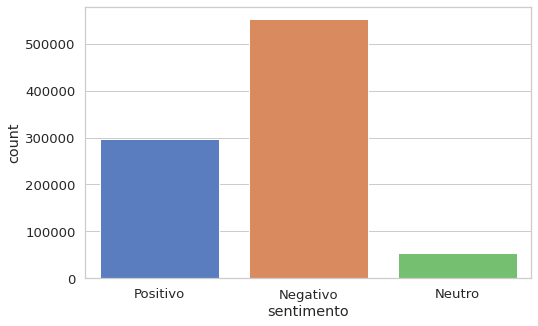

In [4]:
print(data.sentimento.value_counts())
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 8,5
sns.countplot(data.sentimento)

In [5]:
data.texto = data.texto.apply(lambda x: x.lower())
data.texto = data.texto.apply(lambda x: sub('(@[a-zA-z]+[a-zA-Z0-9-_]+)', '', x))
data.texto = data.texto.apply(lambda x: sub('(#[a-zA-Z]+[a-zA-Z0-9-_]+)', '', x))
data.texto = data.texto.apply(lambda x: sub('([0-9])','',x))
data.texto = data.texto.apply(lambda x: sub('\<http.+?\>', '', x))
data.texto = data.texto.apply(lambda x: sub('rt', '', x))
data.texto = data.texto.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
data.texto = data.texto.apply(lambda x: sub(' +', ' ', x))

/home/rafael/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
data

,texto,sentimento
0,para eu ir,Positivo
1,o meu like eu já dei na época,Positivo
2,eu só queria conseguir comer alguma coisa pra ...,Positivo
3,d que lindo dia,Positivo
4,pq da pr jeitoé uma ofea ha q aproveitar p,Positivo
...,...,...
61586,as concorrentes estão prontas para tudo p love...,Positivo
61587,falei de um já pensando em conectar com o gov...,Positivo
61588,eu comecei isentao pesquisei bastante baixei ...,Positivo
61589,que coisa mais triste uma amiga defendendo um ...,Negativo


In [7]:
tm = []
for t in data.texto:
    tm.append(len(t.split(' ')))
tamanho_txt = np.max(tm)
tamanho_txt

85

Text(0.5, 0, 'Comprimento dos Tokens')

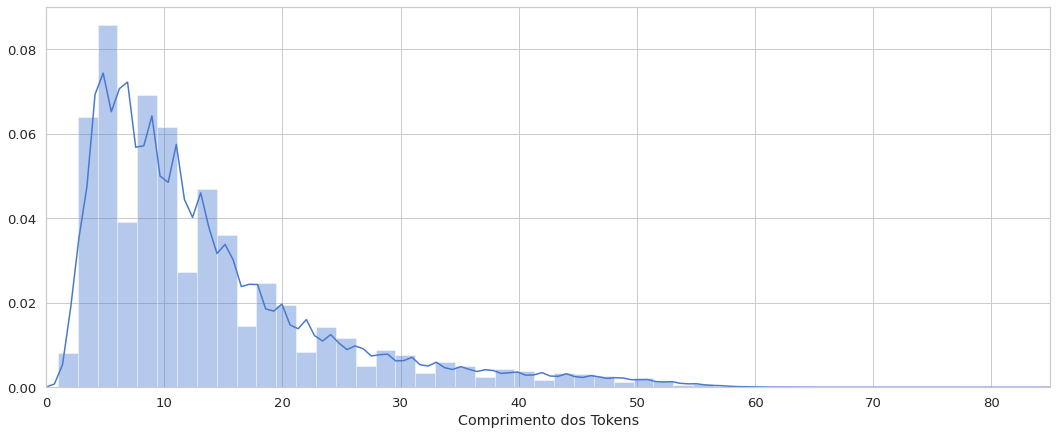

In [8]:
plt.figure(figsize=(18,7))
ax = sns.distplot(tm)
plt.xlim([0,85])
plt.xlabel('Comprimento dos Tokens')

In [9]:
tk = Tokenizer()
tk.fit_on_texts(data.texto.values)
word_index = tk.word_index
total_palavras = len(word_index)
print('Total de palavras: ', total_palavras)

Total de palavras:  440609


In [10]:
minimo = 4
contador = 0
total_contador = 0
frequencia = 0
total_frequencia = 0

for k,v in tk.word_counts.items():
    total_contador += 1
    total_frequencia += v
    if(v < minimo):
        contador += 1 
        frequencia += v
        
print('Palavras raras: ', contador)
print('Tamanho do vocabulário: ', total_contador)
print('Palavras mais comuns: ', total_contador - contador)
palavras = total_contador - contador

Palavras raras:  385794
Tamanho do vocabulário:  440609
Palavras mais comuns:  54815


In [11]:
tamanho_txt = 60

tk = Tokenizer(palavras)
tk.fit_on_texts(list(data.texto))
x = tk.texts_to_sequences(data.texto.values)
x = pad_sequences(x, maxlen=tamanho_txt, padding='post')
x.shape

(900688, 60)

# Salva os tokens

In [12]:
with open('tk.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
y = pd.get_dummies(data.sentimento.values)
y.shape

(900688, 3)

In [14]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = .2)
print(x_treino.shape, y_treino.shape)
print(x_teste.shape, y_teste.shape)

(720550, 60) (720550, 3)
(180138, 60) (180138, 3)


In [15]:
dim = 30

model = Sequential()
model.add(Embedding(palavras, dim, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(21, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
epochs = 100
batch_size = 128

filename = '/media/rafael/11D8AA336028BF21/dataset/melhor_modelo/analise_sentimento_pt.h5'
parada = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
check = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelo = model.fit(x_treino, y_treino, epochs=epochs, batch_size=batch_size, verbose=1,
                   validation_data=(x_teste, y_teste), callbacks=[check, parada])

/home/rafael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 720550 samples, validate on 180138 samples
Epoch 1/100
720550/720550 [==============================] - 14s 19us/step - loss: 0.4990 - accuracy: 0.7814 - val_loss: 0.4207 - val_accuracy: 0.8189

Epoch 00001: val_loss improved from inf to 0.42068, saving model to /media/rafael/11D8AA336028BF21/dataset/melhor_modelo/analise_sentimento_pt.h5
Epoch 2/100
720550/720550 [==============================] - 13s 18us/step - loss: 0.4081 - accuracy: 0.8256 - val_loss: 0.4128 - val_accuracy: 0.8214

Epoch 00002: val_loss improved from 0.42068 to 0.41278, saving model to /media/rafael/11D8AA336028BF21/dataset/melhor_modelo/analise_sentimento_pt.h5
Epoch 3/100
720550/720550 [==============================] - 13s 19us/step - loss: 0.3896 - accuracy: 0.8337 - val_loss: 0.4089 - val_accuracy: 0.8233

Epoch 00003: val_loss improved from 0.41278 to 0.40888, saving model to /media/rafael/11D8AA336028BF21/dataset/melhor_modelo/analise_sentimento_pt.h5
Epoch 4/100
720550/720550 [===================

In [17]:
loss, acc = model.evaluate(x_teste, y_teste)
print('Acurácia: ', acc*100)

180138/180138 [==============================] - 4s 20us/step
Acurácia:  82.20364451408386


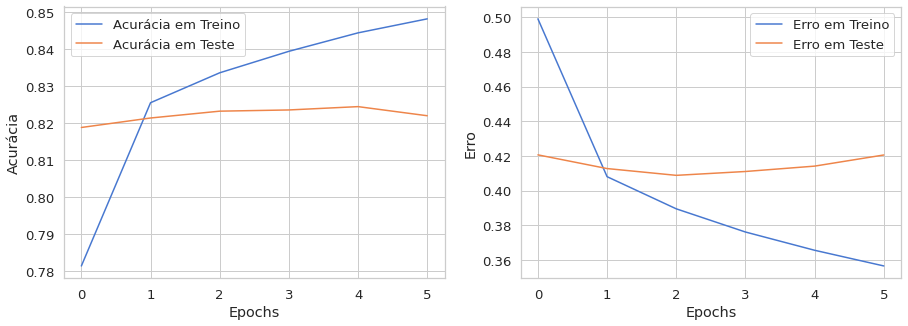

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(modelo.history['accuracy'])
axes[0].plot(modelo.history['val_accuracy'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Acurácia')
axes[0].legend(['Acurácia em Treino','Acurácia em Teste'])
axes[0].grid(True)

axes[1].plot(modelo.history['loss'])
axes[1].plot(modelo.history['val_loss'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Erro')
axes[1].legend(['Erro em Treino','Erro em Teste'])
axes[1].grid(True)

# Fazendo previsões

In [19]:
# Carregaos tokens
with open('tk.pickle', 'rb') as handle:
    tk = pickle.load(handle)

frase = 'Hoje eu tive um dia terrivel!!!'


pre = tk.texts_to_sequences(frase)
pre = pad_sequences(pre, maxlen=60, padding='post')

saida = model.predict_classes(pre, batch_size=1, verbose=0)[0]
if(np.argmax(saida) == 0):
    print('Negativo')
if(np.argmax(saida == 1)):
    print('Neutro')
if(np.argmax(saida == 2)):
    print('Positivo')

Negativo
